# LoRA Basics Summary

## 1. What is LoRA?
- **LoRA = Low-Rank Adaptation of Large Language Models**
- Belongs to **PEFT (Parameter Efficient Fine-Tuning)**
- Key idea:  
  - Freeze pretrained model weights  
  - Inject small trainable low-rank matrices (adapters) into transformer layers
- Benefits
    - Parameter efficiency (freeze big model, only train small adapters)
    - Memory efficient (works on single GPU for big LLMs)
    - Modular (can swap adapters for different tasks)

## 2. Core Mechanism
- Adaptor of pretrained model
    - adaptor is small
    - pretrained model is big
- Specific operations
    - freeze pretrained model weights
    - injects trainable rank decomposition matrices
        - into each layer of transformer architecture
- Lora works mainly on transformer **self-attention projections**: $W_q$, $W_k$, $W_v$, $W_o$
    - Full fine-tune first, then do fine-tune, get ΔW
        - ΔW indicates the parameters change after fine-tuning, the shape and dimension are very big
    - **Lora replace ΔW with low-rank factorization ($W_A$ $W_B$)** -> $ΔW = B A$

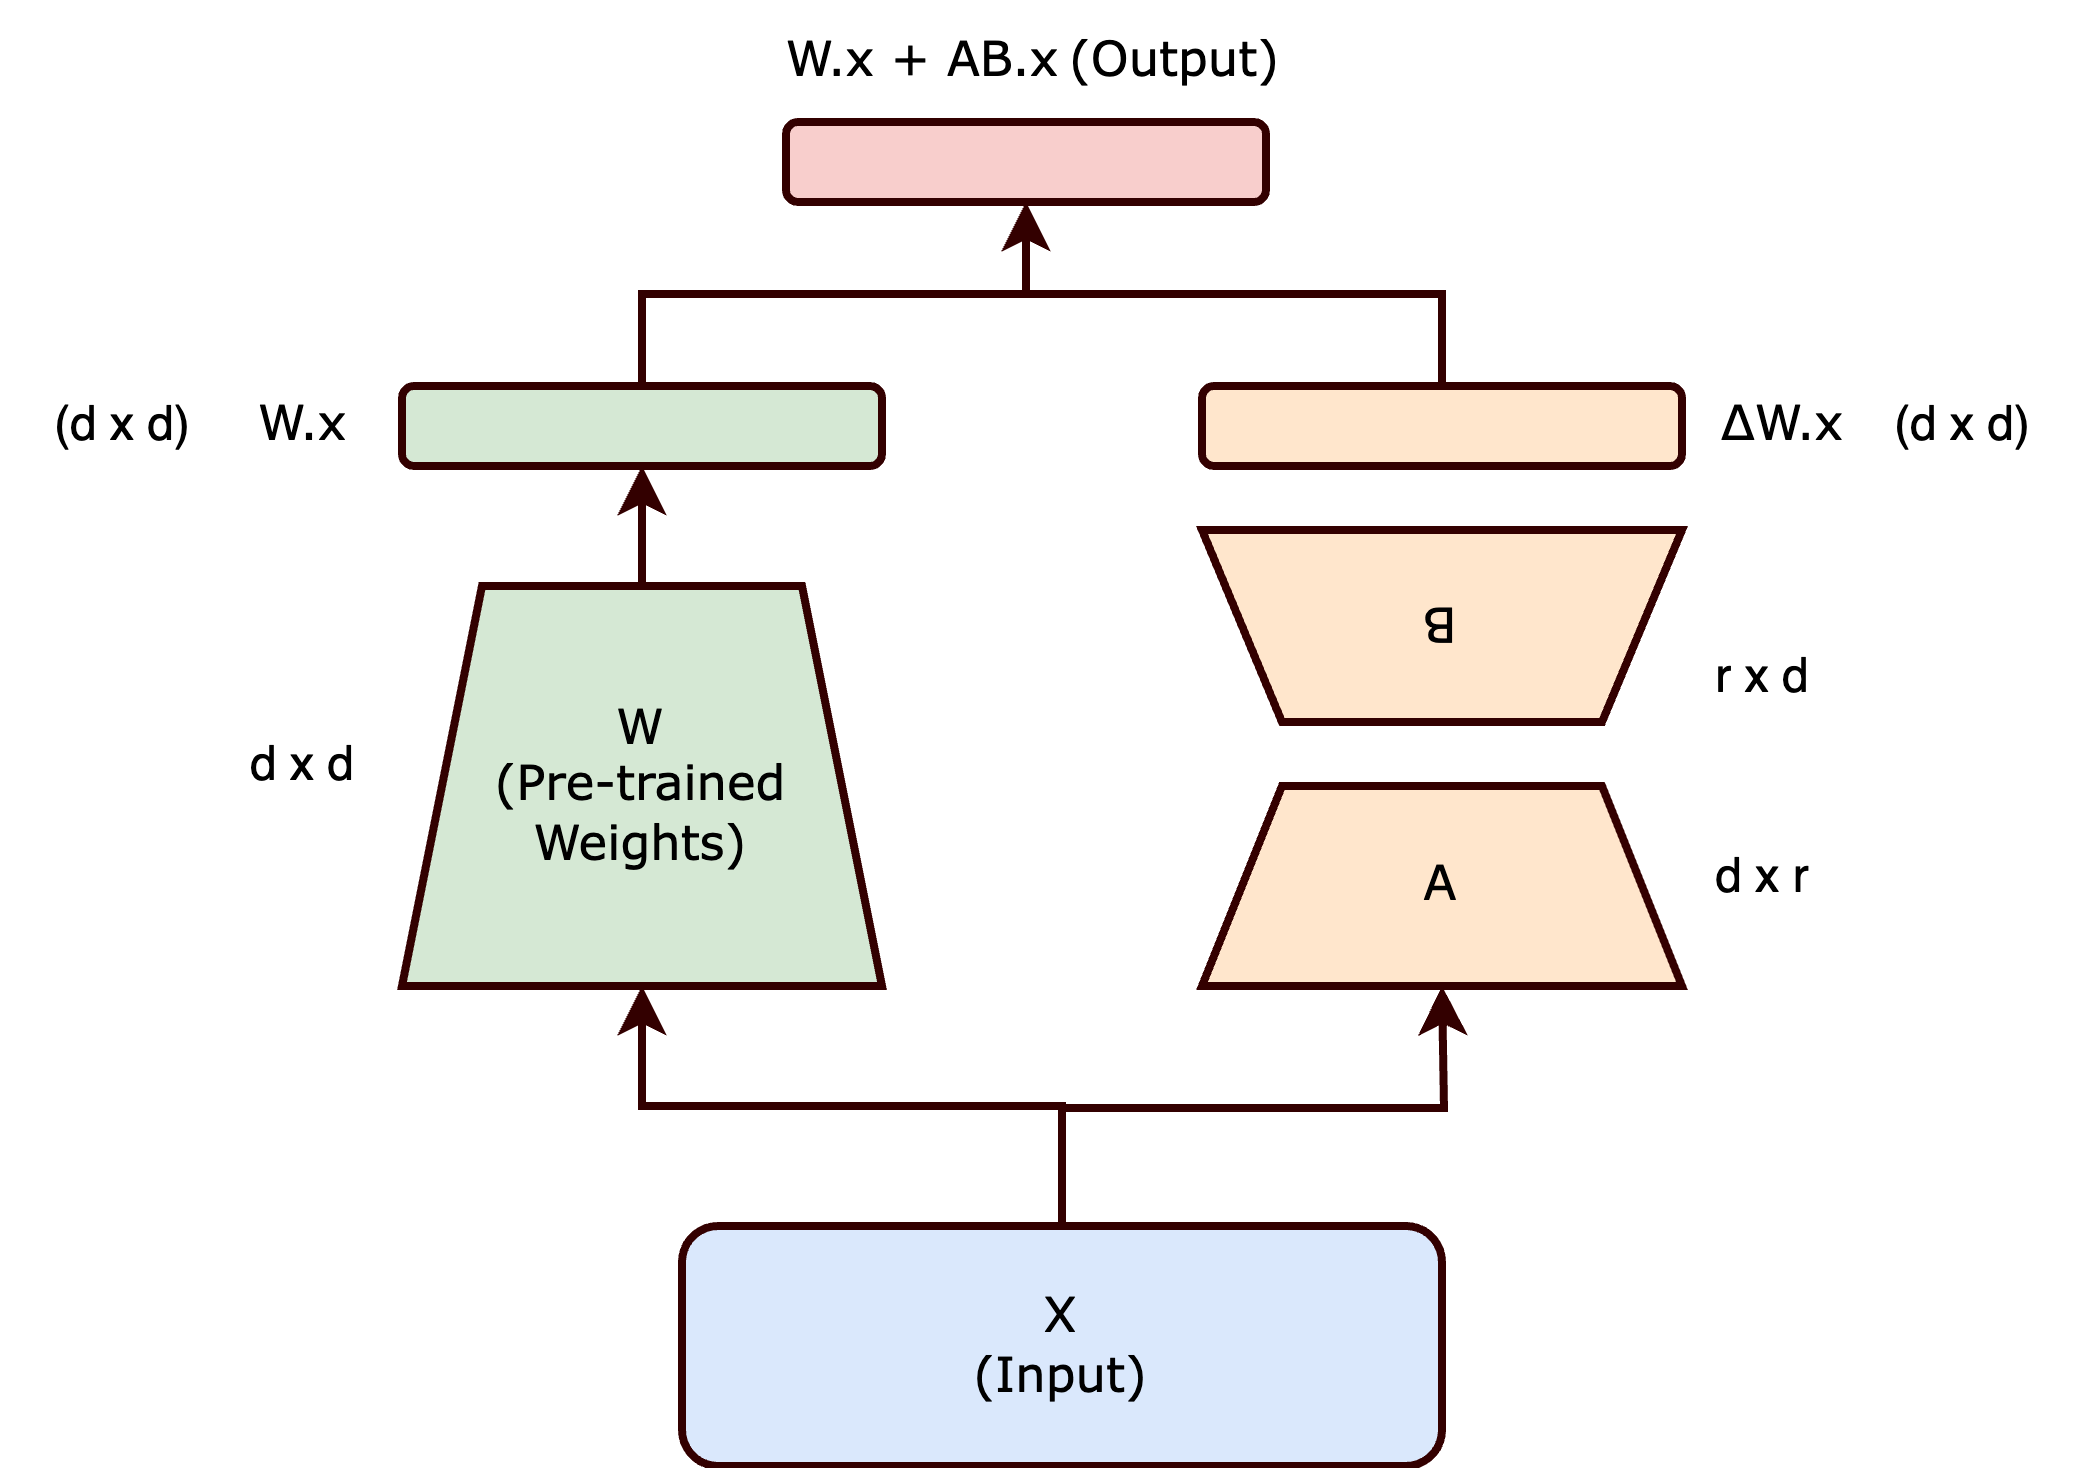

In [7]:
from IPython.display import Image
Image(filename='../images/lora.png', width=600)

# d = size of hidden_state

- In LoRA: only update small matrices Θ, much fewer parameters  
  - $ΔW ≈ W_A W_B$, where $W_A ∈ R^{(A×r)}$, $W_B ∈ R^{(r×B)}$, $r ≪ A,B$
  - Parameter count reduced from $A×B$ to $r×A + r×B$
  - Example: A=100, B=500, r=5
      - A×B = 50000, r×A + r×B = 3000
      - only ~6% of original params

## 3. Row-vector vs Column-vector Conventions (with LoRA)

### 3.1 Column-vector convention (common in math & papers)

- Input: a single sample as a **column vector**  
$$x ∈ ℝ^{d_{in} × 1}$$

- Weight matrix:  
$$W ∈ ℝ^{d_{out} × d_{in}}$$

- LoRA decomposition:  
$$ΔW = B A$$  
$$A ∈ ℝ^{r × d_{in}},\; B ∈ ℝ^{d_{out} × r}$$

- Forward pass:  
$$y = W x + ΔW x = W x + B (A x)$$  
Shapes:  
- $A x: (r × d_{in}) @ (d_{in} × 1) → (r × 1)$  
- $B (A x): (d_{out} × r) @ (r × 1) → (d_{out} × 1)$  
- $y ∈ ℝ^{d_{out} × 1}$  

- Batch version: (each column is one sample)  
$$X ∈ ℝ^{(d_{in} × B)}$$  
$$Y = W X + B (A X)$$  
$$Shape: (d_{out} × d_{in}) @ (d_{in} × B) → (d_{out} × B)$$


### 3.2 Row-vector convention (common in code frameworks)

- Input: a batch as **row vectors** (each row is one sample)  
$$X ∈ ℝ^{B × d_{in}}$$  

- Weight matrix:  
$$W ∈ ℝ^{(d_{out} × d_{in})}$$  

- LoRA decomposition:  
$$ΔW = B A$$  
$$A ∈ ℝ^{r × d_{in}},\; B ∈ ℝ^{d_{out} × r}$$  

- Forward pass:  
$$Y = X Wᵀ + (X Aᵀ) Bᵀ$$  
Shapes:  
- $X Aᵀ: (B × d_{in}) @ (d_{in} × r) → (B × r)$  
- $(X Aᵀ) Bᵀ: (B × r) @ (r × d_{out}) → (B × d_{out})$  
- $Y ∈ ℝ^{B × d_{out}}$

- Single sample (B=1):  
$$x ∈ ℝ^{(1 × d_{in})}$$  
$$y = x Wᵀ + (x Aᵀ) Bᵀ ∈ ℝ^{(1 × d_{out})}$$


### 3.3 Key differences

- **Input orientation**:  
  - Column-vector: each sample is $(d_{in} × 1)$  
  - Row-vector: each sample is $(1 × d_{in})$  

- **Formula (LoRA included)**:  
  - Column-vector: $y = W x + B (A x)$  
  - Row-vector: $y = x Wᵀ + (x Aᵀ) Bᵀ$  

- **Batching**:  
  - Column-vector: stack as columns $(X ∈ ℝ^{(d_{in} × B)})$  
  - Row-vector: stack as rows $(X ∈ ℝ^{(B × d_{in})})$  

- **Output shape**:  
  - Column-vector: $y ∈ ℝ^{(d_{out} × 1)}$  
  - Row-vector: $y ∈ ℝ^{(1 × d_{out})}$  

### 3.4 Mental bridge

Remember:  
- **Math / paper form (column-vector)**:  
$$y = W x + B (A x)$$  

- **Code / row-vector form**:  
$$Y = X Wᵀ + (X Aᵀ) Bᵀ$$

---

## 4 Pseudocode

- r is a Hyperparameter: a trade-off between model complexity, adaptation capacity, and the risk of underfitting or overfitting  
  - A smaller r leads to a simpler low-rank matrix, which results in fewer parameters to learn during adaptation.  
    - This can lead to faster training and potentially reduced computational requirements.  
  - However, with a smaller r, the capacity of the low-rank matrix to capture task-specific information decreases.  
    - This may result in lower adaptation quality, and the model might not perform as well on the new task compared to a higher r.  


```python
input_dim = 768   # e.g., the hidden size of the pre-trained model
output_dim = 768  # e.g., the output size of the layer
rank = 8          # The rank 'r' for the low-rank adaptation

W = ...  # from pretrained network with shape input_dim x output_dim

W_A = nn.Parameter(torch.empty(input_dim, rank))       # LoRA weight A -> [hidden_states, rank]
W_B = nn.Parameter(torch.empty(rank, output_dim))      # LoRA weight B ->  [hidden_states, rank]

# Initialization of LoRA weights
nn.init.kaiming_uniform_(W_A, a=math.sqrt(5))
nn.init.zeros_(W_B)


def regular_forward_matmul(x, W):
    h = x @ W
    return h


def lora_forward_matmul(x, W, W_A, W_B):
    h = x @ W   # regular matrix multiplication
    h += x @ (W_A @ W_B) * alpha   # use scaled LoRA weights
    return h
